Importing the lybraries

In [ ]:
from firedrake import *
import numpy as np
import finat
from scipy import optimize
import sys
from mpi4py import MPI
OMP_NUM_THREADS=1

import spyro

Defining the model setup

In [ ]:
import os
from spyro import create_transect

# Choose method and parameters
# Choose method and parameters
opts = {
    "method": "KMV",
    "quadrature": "KMV",
    "degree": 1,  # p order
    "dimension": 2,  # dimension
}

parallelism = {
    "type": "automatic",  # options: automatic (same number of cores for evey processor), custom, off.
    "custom_cores_per_shot": [],  # only if the user wants a different number of cores for every shot.
    "num_cores_per_shot": 1
}

mesh = {
    "Lz": 2.,  # depth in km - always positive
    "Lx": 2.,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "meshes/circle.msh",
}

BCs = {
    "status": False,  # True,  # True or false
    "outer_bc": "non-reflective",  # "non-reflective",  #  neumann, non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial. hyperbolic, shifted_hyperbolic
    "method": "damping", # damping, pml
    "exponent": 2,
    "cmax": 4.7,  # maximum acoustic wave velocity in PML - km/s
    "R": 0.001,  # theoretical reflection coefficient
    "lz": 0.5,  # thickness of the pml in the z-direction (km) - always positive
    "lx":0.5,  # thickness of the pml in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the pml in the y-direction (km) - always positive
}
acquisition = {
    "source_type": "Ricker",
    "frequency": 7.0,
    "delay": 1.0,
    # "num_sources": 1,
    "num_sources": 4,
    "source_pos": create_transect((0.6, -0.1), (1.4, -0.1), 4),
    "amplitude": 1.0,
    "num_receivers": 10,
    "receiver_locations": create_transect((0.6, -0.2), (1.4, -0.2), 10),
}

timeaxis = {
    "t0": 0.0,  #  Initial time for event
    "tf": 1.0,  # Final time for event
    "dt": 0.001,  # timestep size
    "nspool": 1001,  # how frequently to output solution to pvds
    "fspool": 1,  # how frequently to save solution to RAM
}  # how freq. to output to files and screen

inversion = {
    "freq_bands": [None]
}  # cutoff frequencies (Hz) for Ricker source and to low-pass the observed shot record


# Create your model with all the options
model = {
    "self": None,
    "inversion": inversion,
    "opts": opts,
    "BCs": BCs,
    "parallelism": parallelism,
    "mesh": mesh,
    "acquisition": acquisition,
    "timeaxis": timeaxis,
}

True velocity model

In [ ]:
def _make_vp(V, mesh, vp_guess=False):
    """creating velocity models"""
    x,z = SpatialCoordinate(mesh)
    if vp_guess:
        vp   = Function(V).interpolate(1.5 + 0.0 * x)
        File("guess_vel.pvd").write(vp)
    else:
        vp  = Function(V).interpolate(
            2.5
            + 1 * tanh(20 * (0.125 - sqrt(( x - 1) ** 2 + (z + 0.5) ** 2)))
            # 5.0 + 0.5 * tanh(10.0 * (0.5 - sqrt((z - 1.5) ** 2 + (x + 1.5) ** 2)))
        )
      
        File("exact_vel.pvd").write(vp)
      
    
    return vp

comm = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)

vp   = _make_vp(V,mesh)

Point cloud definition used to compute the objective functional.

In [ ]:
num_rec = model["acquisition"]["num_receivers"]
δs = np.linspace(0.6, 1.4, num_rec)
X, Y = np.meshgrid(δs, -0.2)
xs = np.vstack((X.flatten(), Y.flatten())).T
point_cloud = VertexOnlyMesh(mesh, xs)
P = FunctionSpace(point_cloud, "DG", 0)

source_pos =  model["acquisition"]["source_pos"]
rec_pos    =  model["acquisition"]["receiver_locations"]

Here, the wave propagation solver has the goal to get the displacement at the receivers for the true velocity model. In this case, It is not necessary to annotate the code. Therefore, the automatic differentiation is not employed and the set up used is as showed below.

In [ ]:
aut_dif=False

Running the foward wave equation with the true velocity model.

In [ ]:
solver  = spyro.solver_AD(Aut_Dif=aut_dif)

i=0
rec = []

for sn in source_pos:
    rec.append(solver.wave_propagation(model,mesh,comm,vp,P,sn))
    i+=1

Let us start the FWI process.

In [ ]:
obj_ad  = []
obj_da  = []

In [ ]:
comm = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)

vp   = _make_vp(V,mesh)

num_rec = model["acquisition"]["num_receivers"]
δs = np.linspace(0.6, 1.4, num_rec)
X, Y = np.meshgrid(δs, -0.2)
xs = np.vstack((X.flatten(), Y.flatten())).T
point_cloud = VertexOnlyMesh(mesh, xs)
P = FunctionSpace(point_cloud, "DG", 0)

def makeMask():
    # Update the local vp_guess function
    x,z = SpatialCoordinate(mesh)
    boxx1 = Function(V).interpolate(conditional(x > 0.5, 1.0, 0.0))
    boxx2 = Function(V).interpolate(conditional(x < 1.5, 1.0, 0.0))
    boxz1 = Function(V).interpolate(conditional(z < -0.1, 1.0, 0.0))
    boxz2 = Function(V).interpolate(conditional(z > -0.8, 1.0, 0.0))
    mask = Function(V).interpolate(boxx1*boxx2*boxz1*boxz2)
    File("mask.pvd").write(mask)
    return mask

mask = makeMask() 



In [ ]:
solver  = spyro.solver_AD(fwi=True,Aut_Dif=aut_dif)
def runFWI(sn,xi):
    
    if solver.Aut_Dif:
        import firedrake_adjoint
    np.save('guess_mm_da',xi)  
    # Spatial communicator rank and size.
    rank = comm.comm.rank
    size = comm.comm.size
    
    vp   = Function(V) 
    n    = len(vp.dat.data[:])
    N    = [comm.comm.bcast(n, r) for r in range(size)]
    indices = np.insert(np.cumsum(N), 0, 0)
    vp.dat.data[:] = xi[indices[rank] : indices[rank+1]]
    #setup to compute the functional objective and to use AD
    print(max(vp.dat.data), min(vp.dat.data))
    File("guess_velocity_mm_da.pvd", comm=comm.comm).write(vp)
    J=0
    if solver.Aut_Dif:
        control = firedrake_adjoint.Control(vp) 
        p_rec,J = solver.wave_propagation(model,mesh,comm,vp,P,source_pos[sn],p_true_rec=rec[sn],obj_func=J)
    else:
        p, misfit, J= solver.wave_propagation(model,mesh,comm,vp,P,source_pos[sn],p_true_rec=rec[sn],obj_func=J)
    
    # spyro.plots.plot_shots(model,comm,misfit,show=True) 
  
    if solver.Aut_Dif:   
        dJdm = firedrake_adjoint.compute_gradient(J, control)
        firedrake_adjoint.get_working_tape().clear_tape()      
    else:
        dJdm   = solver.wave_propagation(model,mesh,comm,vp,P,rec_pos,type="adjoint",misfit=misfit,guess=p)
    
    dJdm *= mask     
    
    return J, dJdm.dat.data[:]



The funtion below runs in parallel the forward and adjoint solvers for every sources.
<!-- 
if solver.Autom_Dif:
        vp_ad.vp.dat.data[:] = xi[indices[rank] : indices[rank+1]]
    else:
        vp_da.vp.dat.data[:] = xi[indices[rank] : indices[rank+1]] -->

In [ ]:
import multiprocessing as mp
def getGradObg(xi):
    nshots = len(source_pos)
    process_pool = mp.Pool(int(nshots/2))
    data   = [(0, xi),(1, xi)]
    data1  = [(2, xi),(3, xi)]
    output = process_pool.starmap(runFWI, data)
    process_pool.close()
    process_pool.join() 
    
    process_pool1 = mp.Pool(int(nshots/2))
    output1 = process_pool1.starmap(runFWI, data1)
    process_pool1.close()
    process_pool1.join() 
    obj = 0
    grad = 0
    
    for j in range(0,int(nshots/2)):

        obj  += output[j][0]
        grad += output[j][1]
        obj  += output1[j][0]
        grad += output1[j][1]
        
    if solver.Aut_Dif:
        obj_ad.append(obj)
    else:
        obj_da.append(obj)
    
    return obj, grad


In this case, FWI uses the discrete adjoint wave equation to compute de gradient.

In [ ]:
init_vel = _make_vp(V,mesh,vp_guess=True)

vmax   = 3.5
vmin   = 1.5
m0 = init_vel.vector().gather()
bounds  = [(vmin,vmax) for _ in range(len(m0))] 
result_da  = optimize.minimize(getGradObg, m0,method='L-BFGS-B', jac=True, tol = 1e-15, bounds=bounds, options={"disp": True,"eps": 1e-15, "gtol": 1e-15,"maxiter": 10})

rank = comm.comm.rank
size = comm.comm.size

vp_da   = Function(V) 
n    = len(vp.dat.data[:])
N    = [comm.comm.bcast(n, r) for r in range(size)]
indices = np.insert(np.cumsum(N), 0, 0)
vp_da.dat.data[:] = result_da.x[indices[rank] : indices[rank+1]]
File("guess_velocity_da.pvd", comm=comm.comm).write(vp_da)


In [ ]:
solver.Aut_Dif=True
init_vel = _make_vp(V,mesh,vp_guess=True)

vmax   = 3.5
vmin   = 1.5
m0 = init_vel.vector().gather()
bounds  = [(vmin,vmax) for _ in range(len(m0))] 
result_ad  = optimize.minimize(getGradObg, m0,method='L-BFGS-B', jac=True, tol = 1e-15, bounds=bounds, options={"disp": True,"eps": 1e-15, "gtol": 1e-15,"maxiter": 10})

rank = comm.comm.rank
size = comm.comm.size

vp_ad   = Function(V) 
n    = len(vp_ad.dat.data[:])
N    = [comm.comm.bcast(n, r) for r in range(size)]
indices = np.insert(np.cumsum(N), 0, 0)
vp_ad.dat.data[:] = result_ad.x[indices[rank] : indices[rank+1]]
File("guess_velocity_ad.pvd", comm=comm.comm).write(vp_ad)


Running FWI with AD

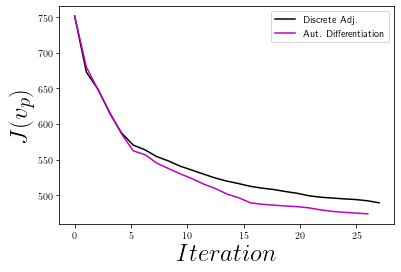

In [8]:
import matplotlib.pyplot as plt
import numpy as np

iteration_da=np.linspace(0,len(obj_da),num=len(obj_da))
iteration_ad=np.linspace(0,len(obj_ad),num=len(obj_ad))
plt.plot(iteration_da,obj_da,'k',label=r'Discrete Adj.')
plt.plot(iteration_ad,obj_ad,'m',label=r'Aut. Differentiation')
plt.ylabel(r'\Huge{$J(v_p)$}', fontsize=24)
plt.xlabel(r'\Huge{$Iteration$}', fontsize=24)
plt.legend(loc='upper right')


In [ ]:
t_ad = 1163
t_da = 140